# Vehicle Detection

In [82]:
import numpy as np
import cv2
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

### 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier (e.g. a Linear SVM classifier)


#### 1.1 Set up helper functions for extracting HOG and colour features

In [108]:
# Adapted from Udacity L22 lesson_functions.py

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, 
                        viz=False, viz_only=False, hog_viz_name="", viz_title="HOG Viz"):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if viz == True:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature, hog_image = get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=True, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                # Plot HOG visualisation
                
                if viz_only == True:
                    fig = plt.figure()
                    plt.imshow(hog_image)
                    plt.title(viz_title)
                    plt.savefig(hog_viz_name, bbox_inches='tight')
                    
                else:
                    fig = plt.figure()
                    plt.subplot(121)
                    plt.imshow(image)
                    plt.title('Example Image')
                    plt.subplot(122)
                    plt.imshow(hog_image)
                    plt.title('Example HOG viz')
                    plt.savefig(hog_viz_name + "_double", bbox_inches='tight')
                
            else:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature = get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

#### 1.2 Prepare data for classifier (extract features)

In [143]:
# Read in cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')


# TODO: Remove
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

# Check that arrays are not empty
print(cars[0])
print(notcars[0])

vehicles/GTI_Far/image0000.png
non-vehicles/Extras/extra1.png


[array([  2.06862748e-01,   3.03921580e-01,   3.02941203e-01,
          1.67647064e-01,   2.56862760e-01,   2.50980407e-01,
          1.56862751e-01,   2.29411766e-01,   2.30392158e-01,
          2.44117662e-01,   3.01960796e-01,   3.03921580e-01,
          4.45098042e-01,   4.85294133e-01,   4.89215702e-01,
          3.42156887e-01,   3.85294139e-01,   3.89215708e-01,
          2.87254930e-01,   3.25490206e-01,   3.32352936e-01,
          2.53921568e-01,   2.85294116e-01,   2.91176498e-01,
          2.45098054e-01,   2.70588249e-01,   2.82352954e-01,
          3.17647070e-01,   3.40196073e-01,   3.51960778e-01,
          3.56862754e-01,   3.82352948e-01,   3.93137276e-01,
          4.40196097e-01,   4.52941179e-01,   4.57843155e-01,
          4.74509805e-01,   4.91176486e-01,   5.01960814e-01,
          2.22549021e-01,   2.70588249e-01,   2.78431386e-01,
          2.24509805e-01,   2.85294116e-01,   2.90196091e-01,
          2.24509805e-01,   2.66666681e-01,   2.75490224e-01,
        

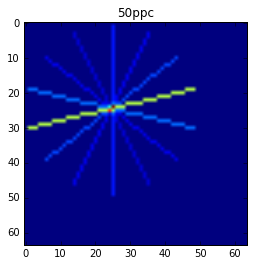

In [144]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7  # HOG orientations
pix_per_cell = 50 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()
image_file_name = "hogviz/rgb_ss1616_hb_16_TTT/" + "o" + str(orient) \
                    + "_ppc" + str(pix_per_cell) + "_cpb" \
                    + str(cell_per_block) + "_hc" + str(hog_channel)
image_title = str(pix_per_cell) + "ppc"
logfilepath = "logs/hogviz_experiments/ppc_exp1.md"

sample_car = [cars[42]]
sample_notcar = [notcars[42]]

extract_features(sample_car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,
                        viz=True, viz_only=True, viz_title=image_title, hog_viz_name=image_file_name)

In [145]:
# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 7 orientations 50 pixels per cell and 2 cells per block
Feature vector length: 816


### Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

Experimenting with 21.26
`colorspace, orient, pix_per_cell, cell_per_block, and hog_channel`


```
4.5 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 8100
Color space:  RGB
Hog channel:  0
0.25 Seconds to train SVC...
Test Accuracy of SVC =  0.955
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  0.  0.  1.]
0.00115 Seconds to predict 10 labels with SVC
```

#### 1.3 Train classifier

In [146]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
training_time = round(t2-t, 4)
print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

with open(logfilepath, "a") as f:
    f.write("\n\n" + str(image_file_name))
    f.write("\nParameters:")
    f.write("\ncolor_space: " + str(color_space))
    f.write("\norient: " + str(orient))
    f.write("\npix_per_cell: " + str(pix_per_cell))
    f.write("\ncell_per_block: " + str(cell_per_block))
    f.write("\nhog_channel: " + str(hog_channel))
    f.write("\nspatial_size: " + str(spatial_size))
    f.write("\nhist_bins: " + str(hist_bins))
    f.write("\nspatial_feat: " + str(spatial_feat))
    f.write("\nhist_feat: " + str(hist_feat))
    f.write("\nhog_feat: " + str(hog_feat))
    f.write('\nFeature vector length:' + str(len(X_train[0])))
    f.write("\n" + str(training_time) + 'Seconds to train SVC...')
    f.write('\nTest Accuracy of SVC = ' + str(svc_score))

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)

0.2857 Seconds to train SVC...
Test Accuracy of SVC =  0.975

Parameters:
color_space:  RGB
orient:  7
pix_per_cell:  50
cell_per_block:  2
hog_channel:  0
spatial_size:  (16, 16)
hist_bins:  16
spatial_feat:  True
hist_feat:  True
hog_feat:  True


### 2. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [147]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    

y_start_stop:  [400, 720]


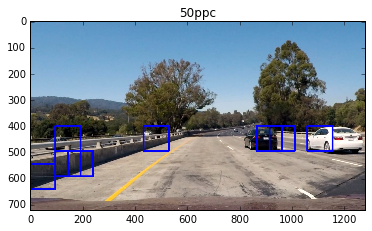

In [148]:
print("y_start_stop: ", y_start_stop)

image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.title(image_title)
plt.imshow(window_img)
plt.savefig(image_file_name + "_window")

### 4. Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

[MoviePy reference](https://zulko.github.io/moviepy/crash_course/crash_course.html)

#### Combine multiple detections and remove false positives

### 5. Estimate a bounding box for vehicles detected.